In [1]:
import numpy as np
import scipy as sp
from scipy.stats import unitary_group
from datetime import datetime
import matplotlib.pyplot as plt
import qutip as qt
#from scipy.optimize import curve_fit
import os
import uuid
from itertools import repeat, chain, product, combinations
from joblib import Parallel, delayed
import time
from EMQST_lib import support_functions as sf
from EMQST_lib import emqst
from EMQST_lib.qst import QST  
from EMQST_lib.povm import POVM, load_random_exp_povm
from EMQST_lib import dt
from EMQST_lib import measurement_functions as mf
from EMQST_lib import visualization as vis
from EMQST_lib import overlapping_tomography as ot
from functools import reduce
from cvxopt import matrix, solvers


%load_ext autoreload
%autoreload 2


## Scalable QREM for separable states.

We start out by considering separable states for both simple simulationa and very scalable results. 

For scalable QREM it is only nessecary to use $k = 2$ hashes. We will however use $k = 4$ hashes to make sure we can easily ask for arbitrary correlators afterwards, without changing the base code. 

### Overlapping tomography: 
For this we require a perfect family of hashing functions, denoted by $(N,k,m,m)$, where $N$ is the total number of hashing fuctions, $k$ is the size of the total system and m is the size of the subsystem you want to reconstruct arbitrary correlators. The number of hashing functions scales exponentially in $k$, but logarithmically in $m$.


### Step by step layout of the separable state code
1. Perform efficient Quantum detector overlapping tomography (QDOT)
    1. Create/load the hashing for the spesified protocol.
    2. Overlapping QDT
        1. Create a set of calibration states according to hashing function. This is effectivly to split total system up into $m$ subgroups that are effectivly treated as a single qubit. This means the set of calibration states scales as $4^m$.
        2. For each hashing function, measure the complete set of calibration states in the computational basis. 
    3. Perform overlapping tomography measurements. (See original paper [here](https://link.aps.org/doi/10.1103/PhysRevLett.124.100401), a more efficient variant for 2-local RDMS can be found [here](https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.2.023393))
        1. Use the same hashing functions from step 1. and create a set of Pauli-6 measurements from these hashing functions. (Similarly as before, it splits the whole system into $m$ subsystems that are effecitvly treated as a single qubit. One then perform an IC POVM on these effective single qubits.) Each hasing function is a different assignment over the whole qubit system.
        2. Measure the qubit system of interest with the hashed Pauli-6 POVMs.
    4. Save all results to file.

2. Extract correlation strucutre
    1. Reconstruct all possible 2 qubit POVM between all the qubits.
    2. Extract the quantum correlation coefficients from each 2 qubit POVM.
    3. Use a cluster-finding algorithm to assign a cluster structure to all qubits 
    4. Redo QDT with the found cluster structure (if not already used $k = 4$ QDOT earlier)
    5. Reconstruct the POVMs on the found noise clusters.
    
3. Perform error mitigated QST. Since we assume the underlying states are separable, there is no limit to how large the correlators we can estimate are. 
    1. Perform IC QST measurments on all clusters.
    2. Reconstruct the state on each cluster. This gives total cluster state $\rightarrow \rho = \otimes_s \rho_s$ for $s\in$ clusters. 
    3. Compute correlators as $Tr(O\rho)$ where $O$ is some operator (this can be done efficiently as the max subsystem size is capped. )

4. (Optionally) Compare to other methods, such as classial only. Correlator only, separable only....

## 1. QDOT

Define simulation parameters.
Select POVM noise:
1. Generate artifical noise sources
    1. Single qubit depolarzing noise
    2. Unitary cluster noise (randomly generates cluster sizes from 0 to cluster_cap)
    3. 2 qubit (CNOT or ISWAP) between neighboring qubits, factorized i.e. all clusters are of size 2.
2. Load noisy POVM from experimental run. 

In [2]:
# Define parameters
n_QST_shots = 10**3
n_QDT_shots = 10**4
n_hash_symbols = 4
n_qubits = 16
use_chunks = True # If true, the nois POVMs and sampled will be split into chunks of chunk_size, 
                 # and sampled as genuine chunk-qubit states. Nessecary for entangled states. 
chunk_size = 4 # For entangled sampling states
n_chunks = int(n_qubits/chunk_size)
path = f"EMQST_lib/hash_family/"
save_raw_data = False # If false, only processes data will be saved. If true, raw sample data will be saved as well. 
n_cores = 9


# 1.1. Load/create the hashing use for protocol
if n_hash_symbols>2:
    hash_family = None
    for files in os.listdir(path):
        if files.endswith(f"{n_qubits},{n_hash_symbols}).npy"):
            print(files)
            with open(f'{path}{files}' ,'rb') as f:
                hash_family = np.load(f)
            break # This break is to make sure it does not load a worse hash if it is stored.
    if hash_family is None: 
        raise ValueError("Did not find hash for this combination, please change settings or create relevant perfect hash family.")
else: # For k=2 we can use the 2-RDM hash family
    hash_family = ot.create_2RDM_hash(n_qubits)
n_hashes = len(hash_family)

print("The shot budget of the currents settings are:")
print(f'QDT shots for computational basis reconstruction: {(n_hashes*(4**n_hash_symbols -4) +4):,} x {n_QDT_shots:,}.')
print(f'QST shots for arbitrary {n_hash_symbols}-RDM reconstruction: {(n_hashes*(3**n_hash_symbols -3) +3):,} x {n_QST_shots:,}.')

experimental_run = False
noise_mode = 3
exp_povms_used = [] # array that contains the POVMs used from the experimental list
path_to_experimental_POVMs = "Exp_povms/Extracted_modified"
# Decides noise mode:
# 0: Noiseless measurement
# 1: Single qubit depolarizing noise
# 2: Random chubk-sized qubit noise
# 3: Import random experimental noisy POVM. from path
# 4: Random strenght CNOT noise (2 qubit noise)

# Create povm that is applied to each qubit.
single_qubit_comp_POVM = POVM.generate_computational_POVM(1)[0]


if experimental_run:
    print('Experimental run')	
    single_qubit_pauli_6 = POVM.generate_Pauli_POVM(1) 
    comp_POVM_array = np.array([single_qubit_comp_POVM]*n_qubits)
    
    # These following are only needed for the simulation
else: 
    if noise_mode:
        print(f'Noisy measurement, noise mode {noise_mode}')
        if noise_mode == 1: # Single qubit depolarizing noise
            noisy_POVM = POVM.depolarized_POVM(single_qubit_comp_POVM)
            povm_array = np.array([noisy_POVM]*n_qubits)
            single_qubit_pauli_6 = np.array([POVM.depolarized_POVM(povm) for povm in POVM.generate_Pauli_POVM(1) ])
            cluster_size = np.ones(n_qubits, dtype=int)
            n_clusters = n_qubits
            
        
        elif noise_mode == 2 or noise_mode == 3: # Nontirival cluster noise, that conforms to chunk_size:
            # Mode == 2 is random unitary noise
            # Mode == 3 is extracted from POVMs. 
            # This mode has a variable number of qubits in each cluster, and the noise is applied to the clusters.
            # We create a set number of clusters with different number of qubits in each cluster., capped at 5 qubits.
            print(f"Non-trivial cluster noise")
            if noise_mode == 2: 
                print(f'Using random unitary noise.')
            if noise_mode == 3:
                print(f'Using random noisy POVMs selected from experiments.')
            cluster_cap = 4 # Caps local POMV correlation
            cluster_size = ot.generate_chunk_sizes(chunk_size, n_chunks, cluster_cap)
            print(cluster_size)
            n_clusters = len(cluster_size)
    

            print(f'The total number of qubits are {sum(cluster_size)}, with {n_clusters} clusters.' )
            print(cluster_size)
            #povm_array = [POVM.generate_random_POVM(2,2) ,POVM.generate_random_POVM(2,2), POVM.generate_noisy_POVM(POVM.generate_computational_POVM(2)[0],3)]
            povm_array = []
            for size in cluster_size:
                if noise_mode == 2:
                    comp_povm = POVM.generate_computational_POVM(size)[0]
                    base_POVM_list = comp_povm.get_POVM()
                    #depol = POVM.depolarized_POVM(comp_povm,np.random.rand())
                    #noisy_POVM = POVM.generate_random_POVM(2**size,2**size)#POVM.generate_noisy_POVM(comp_povm,1)
                    noise_transformation = unitary_group.rvs(2**size)
                    k = 0.8 # Mixing strenght (probability)
                    noisy_POVM_list=POVM(k*base_POVM_list + (1-k)*np.einsum('jk,ikl,lm->ijm',noise_transformation.conj().T,base_POVM_list,noise_transformation))
                elif noise_mode == 3:
                    noisy_POVM_list, load_path = load_random_exp_povm(path_to_experimental_POVMs, size)
                    exp_povms_used.append(load_path)
                    
                povm_array.append(noisy_POVM_list)


        elif noise_mode == 4: # Random strenght CNOT noise
            print(f'Random strenght CNOT/ISWAP noise.')
            cluster_cap = 3
            cluster_size = np.ones(int(n_qubits/2),dtype=int)*2
            n_clusters = len(cluster_size)
            local_noise_mode = 1
            print(f'The total number of qubits are {sum(cluster_size)}, with {n_clusters} clusters.' )
            comp_povm_array = POVM.generate_computational_POVM(2)[0].get_POVM()
            
            CNOT=np.array([[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]],dtype=complex)
            ISWAP=np.array([[1,0,0,0],[0,0,1j,0],[0,1j,0,0],[0,0,0,1]],dtype=complex)
 
            noise_transformation = ISWAP
            random_strenght =  np.random.random(int(n_qubits/2))*0.4 + 0.5 # Mixing strenght (probability)
            print(random_strenght)
            povm_array = [POVM(k*comp_povm_array + (1-k)*np.einsum('jk,ikl,lm->ijm',noise_transformation.conj().T,comp_povm_array,noise_transformation)) for k in random_strenght]

            #povm_array = [POVM.generate_noisy_POVM(comp_povm,local_noise_mode)]*n_clusters
        
    else:
        print('Noiseless measurement')
        povm_array = np.array([single_qubit_comp_POVM]*n_qubits)
        single_qubit_pauli_6 = POVM.generate_Pauli_POVM(1) 



# Generate true states, will have shapes # [[theta,phi], ... ] theta in [0,pi], phi in [-pi,pi]
#rho_true_array = np.array([sf.generate_random_pure_state(1) for _ in range(n_qubits)])
#rho_true_angle_array = np.array([sf.get_angles_from_density_matrix_single_qubit(state)[0] for state in rho_true_array])  


# Define an IC calibration basis, here we use the SIC states (by defining the angles (as will be used for state preparation))
one_qubit_calibration_angles = np.array([[[0,0]],[[2*np.arccos(1/np.sqrt(3)),0]],
                                                 [[2*np.arccos(1/np.sqrt(3)),2*np.pi/3]],
                                                 [[2*np.arccos(1/np.sqrt(3)),4*np.pi/3]]])
one_qubit_calibration_states=np.array([sf.get_density_matrix_from_angles(angle) for angle in one_qubit_calibration_angles])


# These are the instructions that that need to be applied to each qubit.
possible_QDT_instructions = np.array([0, 1, 2, 3]) # For QDT we need to measure each of the 4 calibration states.  
# Experiment equivalent =  one_qubit_calibration_angles
possible_QST_instructions = np.array(["X", "Y", "Z"]) # For QST we need to meaure each qubit in the 3 Pauli basis.
 # Experiment equivalent = [[pi/2, 0], [pi/2, pi/2], [0,0]]
 
 
# Define the experimental dictionary


def exp_measurement_func(n_shots, measurement_angle, state_angle, experimental_dictionary):
    """
    This is a mock function for experimental calls. 

    Inputs:
    - n_shots: The number of measurement shots to perform.
    - state_angle: The angle of the state preparation. Has shape (n_qubits, 2).
    - measurement_angle: The angle of the measurement basis. Has shape (n_qubits, 2).
    - experimental_dictionary: A dictionary containing experimental parameters.

    Outputs:
    - results: An np.array of shape (n_shots, n_qubits) representing the measurement outcomes (0 or 1) for each qubit.
    """
    print('Running experimental function')
    print('State angle:', state_angle)
    print('Measurement angle:', measurement_angle)
    print('Returning random results.')
    return np.random.randint(0, 2, (n_shots, n_qubits))
    
# experimental_dictionary = {"experimental_run": experimental_run,
#                            "standard_measurement_function" : exp_measurement_func,
#                            "true_state_angles" : rho_true_angle_array,
#                            "single_qubit_measurement_angles" : np.array([[np.pi/2, 0], [np.pi/2, np.pi/2], [0,0]]),
#                            "comp_measurement_angles" : np.array([[0,0]]*n_qubits),
#                            "one_qubit_calibration_angles" : one_qubit_calibration_angles.reshape(-1,2) # Redefine shape to have correct format.
#                            } # add any other experimental parameters here, even another dictionary.


QDOT_run_dictionary = {
    "n_QST_shots": n_QST_shots,
    "n_QDT_shots": n_QDT_shots,
    "n_hash_symbols": n_hash_symbols,
    "n_qubits": n_qubits,
    "n_cores": n_cores,
    "hash_family": hash_family,
    "n_hashes": n_hashes,
    "experimental_run": experimental_run,
    "noise_mode": noise_mode,
    "povm_array": [povm.get_POVM() for povm in povm_array], # Can be of inhomogenious shape.
    "noise_cluster_size": cluster_size,
    "n_clusters": n_clusters,
    "possible_QDT_instructions": possible_QDT_instructions,
    "possible_QST_instructions": possible_QST_instructions,
    "exp_POVMs_loaded" : exp_povms_used # List of paths to to POVMs used in the noise sumulations. 
    #"experimental_dictionary": experimental_dictionary,
    }


perfect_hash(9,16,4).npy
The shot budget of the currents settings are:
QDT shots for computational basis reconstruction: 2,272 x 10,000.
QST shots for arbitrary 4-RDM reconstruction: 705 x 1,000.
Noisy measurement, noise mode 3
Non-trivial cluster noise
Using random noisy POVMs selected from experiments.
[2, 1, 1, 4, 2, 1, 1, 4]
The total number of qubits are 16, with 8 clusters.
[2, 1, 1, 4, 2, 1, 1, 4]
['Exp_povms/Extracted_modified/2\\q0q1\\2024-10-11_18-41-11_beb902b7-6273-4607-b0e3-6267a6d63f1d\\DT_settings.npy', 'Exp_povms/Extracted_modified/2\\q0q1\\2024-10-11_18-47-53_a90f5066-caee-473d-afa1-ef10c506de5e\\DT_settings.npy', 'Exp_povms/Extracted_modified/2\\q0q1\\2024-10-11_18-54-34_2de815df-32b2-4d4f-8544-6eb15dcd4931\\DT_settings.npy', 'Exp_povms/Extracted_modified/2\\q0q1\\2024-10-11_19-01-16_5b9c05b4-763e-4b47-905e-7c91b319abe3\\DT_settings.npy', 'Exp_povms/Extracted_modified/2\\q0q1\\2024-10-11_19-07-58_b3f4ed89-3ebd-4d63-8f8f-51d371859da0\\DT_settings.npy', 'Exp_povms/Extra

In [3]:
# Make saving folder for this run
# Check if restuls exist:
check_path='QDOT_results'
path_exists=os.path.exists(check_path)
if not path_exists:
    print("Created QDOT_results dictionary.")
    os.makedirs('QDOT_results')

# Generate new dictionary for current run
now=datetime.now()
now_string = now.strftime("%Y-%m-%d_%H-%M-%S_")
dir_name= now_string+str(uuid.uuid4())


data_path=f'QDOT_results/{dir_name}'
os.mkdir(data_path)


# Save run settings
with open(f'{data_path}/run_settings.npy','wb') as f:
    np.save(f,QDOT_run_dictionary)

## 2. Extract correlator structure
Creates 2 qubit POVMs used for correlation extraction. Steps:
1) Creates hash instructions
2) Simulates QDT measurements
3) Reconstructs all possible 2 qubit POVMs. 

In [161]:


# Create QDT instructions based on hashing (covering arrays) 
hashed_QDT_instructions = ot.create_hashed_instructions(hash_family, possible_QDT_instructions, n_hash_symbols)
# Create hashed calibration states
hashed_calib_states = np.array([ot.calibration_states_from_instruction(instruction, one_qubit_calibration_states) for instruction in hashed_QDT_instructions])
print('Hashed calibration states shape:', hashed_calib_states.shape)

# Simulate all instruction measurements
print(f'Simulating QDT measurements for {n_qubits} qubits.')
QDT_outcomes_parallel = Parallel(n_jobs = n_cores, verbose = 5)(delayed(mf.measure_clusters)(n_QDT_shots, povm_array, rho_array, cluster_size) for rho_array in hashed_calib_states)
QDT_outcomes = np.asarray(QDT_outcomes_parallel)

print('QDT outcomes shape:', QDT_outcomes.shape)

# Create a list with all possible subsystem two qubit combinations, to create cluster map

def get_all_subsystem_labels(n_qubits):
    """
    Function creates all possible combinations of two qubit correlation labels, and corresponding qubit label they  labels.
    """
    QDT_subsystem_labels = np.array([[1,0]])
    # Since the quantum correlation coefficients are not symmetric, we need to have all combinations with swapped orders too.
    # The 0 index qubit is the one that we want to know the effects from the 1 index qubit on.
    # The POVM is reconstructed with the largest qubit number first. The correlator traces out the 0 qubit first, so we have the ordere [1,0] then [0,1].
    corr_subsystem_labels = np.array([[1,0]])
    for i in range(n_qubits):
        for j in range(i):
            QDT_subsystem_labels = np.append(QDT_subsystem_labels, [[i,j]], axis = 0)
            corr_subsystem_labels = np.append(corr_subsystem_labels, [[i,j],[j,i]], axis = 0)
    QDT_subsystem_labels = QDT_subsystem_labels[1:]
    corr_subsystem_labels = corr_subsystem_labels[1:]
    return QDT_subsystem_labels, corr_subsystem_labels

QDT_subsystem_labels, corr_subsystem_labels = get_all_subsystem_labels(n_qubits)
print(f'Number of 2 qubit POVMs to reconstruct: {len(QDT_subsystem_labels)}')
print(f'Create all possible 2 qubit POVMs for correlation map.')
QDT_index_counts =  Parallel(n_jobs = n_cores, verbose = 5)(delayed(ot.get_traced_out_index_counts)(QDT_outcomes, subsystem_label) for subsystem_label in QDT_subsystem_labels)
QDT_index_counts = np.asarray(QDT_index_counts)

# Reconstruct the POVMs in parallel
def parallel_QDOT(QDT_subsystem_labels, QDT_index_counts, hash_family, n_hash_symbols, n_qubits, one_qubit_calibration_states):
    # Step 1.4 Reconstruct the subsystem POVM
    reconstructed_comp_POVM = ot.QDT(QDT_subsystem_labels,QDT_index_counts, hash_family, n_hash_symbols, n_qubits, one_qubit_calibration_states)
    return reconstructed_comp_POVM

two_point_POVM = Parallel(n_jobs = n_cores, verbose = 10)(delayed(parallel_QDOT)(QDT_subsystem_labels[i], QDT_index_counts[i], hash_family, n_hash_symbols, n_qubits, one_qubit_calibration_states) for i in range(len(QDT_subsystem_labels)))
two_point_POVM = np.asarray(two_point_POVM)
# Save povms

with open(f'{data_path}/two_point_POVM.npy', 'wb') as f:
    np.save(f, np.array( [ povm.get_POVM() for povm in two_point_POVM]))
    
if save_raw_data:
    with open(f'{data_path}/QDT_outcomes.npy', 'wb') as f:
        np.save(f, QDT_outcomes)
    

Hashed calibration states shape: (2272, 16, 2, 2)
Simulating QDT measurements for 16 qubits.


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  54 tasks      | elapsed:   12.1s
[Parallel(n_jobs=9)]: Done 531 tasks      | elapsed:   13.2s
[Parallel(n_jobs=9)]: Done 1539 tasks      | elapsed:   15.8s
[Parallel(n_jobs=9)]: Done 2272 out of 2272 | elapsed:   17.8s finished


QDT outcomes shape: (2272, 10000, 16)
Number of 2 qubit POVMs to reconstruct: 120
Create all possible 2 qubit POVMs for correlation map.


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  54 tasks      | elapsed:   21.9s
[Parallel(n_jobs=9)]: Done 120 out of 120 | elapsed:   48.8s finished
[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   7 tasks      | elapsed:    9.0s
[Parallel(n_jobs=9)]: Done  14 tasks      | elapsed:   18.3s
[Parallel(n_jobs=9)]: Done  23 tasks      | elapsed:   22.2s
[Parallel(n_jobs=9)]: Done  32 tasks      | elapsed:   31.1s
[Parallel(n_jobs=9)]: Done  43 tasks      | elapsed:   40.6s
[Parallel(n_jobs=9)]: Done  54 tasks      | elapsed:   52.2s
[Parallel(n_jobs=9)]: Done  67 tasks      | elapsed:  1.0min
[Parallel(n_jobs=9)]: Done  80 tasks      | elapsed:  1.2min
[Parallel(n_jobs=9)]: Done  95 tasks      | elapsed:  1.4min
[Parallel(n_jobs=9)]: Done 116 out of 120 | elapsed:  1.7min remaining:    3.4s
[Parallel(n_jobs=9)]: Done 120 out of 120 | elapsed:  1.7min finished


Computes the correlation coefficients and then uses them to find the correlation strucutre

In [ ]:

# Compute the quantum and classical correlation coefficients with worst case distance
mode = "WC"
quantum_corr_array = [povm.get_quantum_correlation_coefficient(mode).flatten() for povm in two_point_POVM]
classical_corr_array = [povm.get_classical_correlation_coefficient(mode).flatten() for povm in two_point_POVM]
quantum_corr_array = np.asarray(quantum_corr_array)
classical_corr_array = np.asarray(classical_corr_array)
# print(f'Quantum corr array shape: {quantum_corr_array.shape}')
# print(f'List of two-point correlators shape: {corr_subsystem_labels.shape}')
quantum_corr_array = quantum_corr_array.flatten()
classical_corr_array = classical_corr_array.flatten()
unique_corr_labels = corr_subsystem_labels[::2] # Takes out every other label, since the neighbouring label is the swapped qubit labels. 
summed_quantum_corr_array = np.array([quantum_corr_array[2*i] + quantum_corr_array[2*i+1] for i in range(len(quantum_corr_array)//2)])

# Compute the quantum correlation coefficients with worst case distance
mode = "AC"
quantum_corr_array_AC = [povm.get_quantum_correlation_coefficient(mode).flatten() for povm in two_point_POVM]
classical_corr_array_AC = [povm.get_classical_correlation_coefficient(mode).flatten() for povm in two_point_POVM]
quantum_corr_array_AC = np.asarray(quantum_corr_array_AC)
classical_corr_array_AC = np.asarray(classical_corr_array_AC)
quantum_corr_array_AC = quantum_corr_array_AC.flatten()
classical_corr_array_AC = classical_corr_array_AC.flatten()
summed_quantum_corr_array_AC = np.array([quantum_corr_array_AC[2*i] + quantum_corr_array_AC[2*i+1] for i in range(len(quantum_corr_array_AC)//2)])



# Find the full cluster size of the system
high_corr = np.max(summed_quantum_corr_array)
corr_limit = high_corr*0.1
n_runs  = 10
alpha = 0.5 #0.5
# Create initialpartition
partitions_init = ot.assign_init_cluster(summed_quantum_corr_array,unique_corr_labels,n_qubits,corr_limit)
new_partition = [[i] for i in range(n_qubits)]
print(f'Inital partions: {partitions_init}')
# Optimize cluster structure according to heuristic cost function. 
noise_cluster_labels = ot.optimize_cluster(n_runs,partitions_init,summed_quantum_corr_array,unique_corr_labels,4,corr_limit,alpha)
print(f'Noise cluster: {noise_cluster_labels}')
print(f'')

# Save the correlation data
correlation_dict = {
    "quantum_corr_array": quantum_corr_array,
    "classical_corr_array": classical_corr_array,
    "unique_corr_labels": unique_corr_labels,
    "summed_quantum_corr_array": summed_quantum_corr_array,
    "quantum_corr_array_AC": quantum_corr_array_AC,
    "classical_corr_array_AC": classical_corr_array_AC,
    "noise_cluster_labels": noise_cluster_labels
}
with open(f'{data_path}/cluster_correlation.npy', 'wb') as f:
    np.save(f, correlation_dict)
    

print(f'Cluster structure: {cluster_size}')
it = 0
print("Clusters")
def get_true_clluster_labels(cluster_size):
    true_cluster_labels = []
    it = 0
    rev_cluster_size = cluster_size[::-1]
    for i in range(len(cluster_size)):
        true_cluster_labels.append(np.arange(it, it + rev_cluster_size[i]))
        it+=rev_cluster_size[i]
    return true_cluster_labels[::-1]

true_cluster_labels = get_true_clluster_labels(cluster_size)
for item in true_cluster_labels:
    print(item)



NameError: name 'two_point_POVM' is not defined

Create all the POVMs from the found cluster states

In [167]:
# Create a all POVMS for the noise clusters
QDT_index_counts = [ot.get_traced_out_index_counts(QDT_outcomes, subsystem_label) for subsystem_label in noise_cluster_labels]
clustered_QDOT = Parallel(n_jobs = n_cores,verbose = 10)(delayed(parallel_QDOT)(noise_cluster_labels[i], QDT_index_counts[i], hash_family, n_hash_symbols, n_qubits, one_qubit_calibration_states) for i in range(len(noise_cluster_labels)))

# Create all 1 qubit POVMS for comparison
one_qubit_subsystem_labels = np.array([[i] for i in range(n_qubits)])
one_qubit_QDT_index_counts = [ot.get_traced_out_index_counts(QDT_outcomes, subsystem_label) for subsystem_label in one_qubit_subsystem_labels]
one_qubit_POVMs = Parallel(n_jobs = n_cores,verbose = 10)(delayed(parallel_QDOT)(one_qubit_subsystem_labels[i], one_qubit_QDT_index_counts[i], hash_family, n_hash_symbols, n_qubits, one_qubit_calibration_states) for i in range(len(one_qubit_subsystem_labels)))
#with open('clustered_QDOT.npy', 'wb') as f:
with open(f'{data_path}/clustered_QDOT.npy', 'wb') as f:
    QDT_dict = {
        "clustered_QDOT": [povm.get_POVM() for povm in clustered_QDOT],
    }
    np.save(f, QDT_dict)

#del QDT_outcomes


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   1 tasks      | elapsed:   12.3s
[Parallel(n_jobs=9)]: Done   2 out of   7 | elapsed:   14.2s remaining:   35.6s
[Parallel(n_jobs=9)]: Done   3 out of   7 | elapsed:   14.2s remaining:   18.9s
[Parallel(n_jobs=9)]: Done   4 out of   7 | elapsed:   14.2s remaining:   10.6s
[Parallel(n_jobs=9)]: Done   5 out of   7 | elapsed:   14.3s remaining:    5.7s
[Parallel(n_jobs=9)]: Done   7 out of   7 | elapsed:   41.2s finished
[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   3 out of  16 | elapsed:    4.0s remaining:   17.8s
[Parallel(n_jobs=9)]: Done   5 out of  16 | elapsed:    4.1s remaining:    9.2s
[Parallel(n_jobs=9)]: Done   7 out of  16 | elapsed:    4.2s remaining:    5.4s
[Parallel(n_jobs=9)]: Done   9 out of  16 | elapsed:    9.4s remaining:    7.3s
[Parallel(n_jobs=9)]: Done  11 out of  16 | elapsed:    9.4s remaining:    4.2s

In [168]:
# Compare to true POMVs. 
print(noise_cluster_labels)
# comparison_array = np.array([6,0,5,4,3,8,2,7,1])[::-1]

for i, item in enumerate(clustered_QDOT):
    a = item.get_POVM()
    print(a.shape)
    print(sf.ac_POVM_distance(povm_array[i].get_POVM(),clustered_QDOT[i].get_POVM()))


[array([0, 1]), array([2, 3]), array([4, 5, 6]), array([7]), array([8, 9]), array([10, 11]), array([12, 13, 14, 15])]
(4, 4, 4)
0.08776587391937407
(4, 4, 4)
0.08733003990200919
(8, 8, 8)
0.13462904435238804
(2, 2, 2)
0.08660648360757778
(4, 4, 4)
0.10724501619422995
(4, 4, 4)
0.09652596452847115
(16, 16, 16)
0.16021865169957278


## 3. QST

We do comparison between multiple different approaches to do cluster based readout error mitigation. 

1) No QREM (do nothing special, reconstruct 2RDM based on noisy measurements).
2) Facotrized QREM. 
    Use single qubit QREM and tensor together results.  
3) REM on correlator qubits only.
4) Premade cluster POVM-reduction method. Thus outdated method is based on tracing down the POVM with knowledge of the state of the enviourment that is correlated to the state. Was underperforming. IT is designd as follows: 
    1) Trace down POVM of the cluster POVMs such that only dimension of two-point qubits are left. 
    2) In QST, use the POVM elemet that corresponds to the outcome on the full cluster. 
    3) Estimated state comes out to the corect shape. No more tracing required. 
5) Premade cluster state-reduction method.  Here we use the pre-made custer and reconstruct the state on these clusters indepdendently. Then trace down the relevant cluster states to 2RDM (either factorized from two differnet clusters or two within the same cluster). The steps are as follow:
    1) Reconstruction of the states for the clusters structure.
    2) Find the the correct cluster indecies for those cluster structures. 
    3) Trace down the states to get the correct product states.
    4) If correlator is in two different clusters, tensor together two single qubit states. 

6) Premade cluster state-reduction method with classical errors only. 
7) Entangled cluster reconstruction. 

In [4]:

# Assume perfect recon
clustered_QDOT = povm_array

true_cluster_labels = ot.get_true_cluster_labels(cluster_size)
noise_cluster_labels = true_cluster_labels

hashed_QST_instructions = ot.create_hashed_instructions(hash_family, possible_QST_instructions, n_hash_symbols)
# Generates GHZ states on the whole system (the total )

state_size_array = [chunk_size]*int(n_qubits/chunk_size)	# Set size to max to make sure state is entangled inside the chunk
rho_true_array = [sf.generate_GHZ(size) for size in state_size_array]

rho_true_labels = ot.get_true_cluster_labels(state_size_array)

povm_true_labels = ot.get_true_cluster_labels(cluster_size)
print(f'Noise cluster: {noise_cluster_labels}')
print(f'State size array: {state_size_array}')    
print(f'Label structure rho_true : {rho_true_labels}')
print(f'Label structure POVM: {povm_true_labels}')

n_QST_shots_total = n_QST_shots *1
# Sample hashes outcomes to be used by most comparisons. 
QST_outcomes = mf.measure_hashed_chunk_QST(n_QST_shots_total, chunk_size, povm_array, cluster_size, rho_true_array, state_size_array, hashed_QST_instructions)


# Define the two point correlators to extract: 
# two_point_array = ot.generate_random_pairs_of_qubits(n_qubits,5) # ,[7,9] [3,5]
two_point_array = np.array([[7, 4]])#, [8,10], [4,7],[0,1]])

Noise cluster: [array([14, 15]), array([12, 13]), array([10, 11]), array([8, 9]), array([5, 6, 7]), array([4]), array([2, 3]), array([0, 1])]
State size array: [4, 4, 4, 4]
Label structure rho_true : [array([12, 13, 14, 15]), array([ 8,  9, 10, 11]), array([4, 5, 6, 7]), array([0, 1, 2, 3])]
Label structure POVM: [array([14, 15]), array([12, 13]), array([10, 11]), array([8, 9]), array([5, 6, 7]), array([4]), array([2, 3]), array([0, 1])]


### Entangled state simulation only


In [22]:

entangled_recon_states, entangled_qubit_order = ot.entangled_state_reduction_premade_clusters_QST(two_point_array,
                        noise_cluster_labels, QST_outcomes, clustered_QDOT, hash_family, n_hash_symbols, n_qubits)
# 3 qubits: 4.sec old efficient , 2.8 new_efficient , old 2 sec, old with optimization 1.5 sec  
# 4 qubits: old efficient 38, new_efficient 35, old 27 sec, old with optimization 16 sec
# 5 qubits: old efficient 2.5 min  min, new efficient 2.5 min, old 3 min, old with optimization 1.25 min
# 6 qubits old efficient 16.5 min, new efficient 16.7 min, old min 37+ min, old with optimization 43  mins
# 7 qubits old efficient 30.5 mins, new efficient 28 mins
# 8 Qubits old efficient hours, new efficient 2.5 + hours

# Compare the minimal chunk state with the entangled reconstructed states. 
# Reconstruct relevant states
print(entangled_recon_states[0].shape)
rho_true_list, rho_labels_in_state = ot.tensor_chunk_states(rho_true_array, rho_true_labels, noise_cluster_labels, two_point_array)

traced_down_rho_true = [ot.trace_down_qubit_state(rho_true_list[i], rho_labels_in_state[i], np.setdiff1d(rho_labels_in_state[i], entangled_qubit_order[i])) for i in range(len(rho_true_list))]
Z = np.array([[1,0],[0,-1]])
id = np.array([[1,0],[0,1]])
# array = [Z, id,id,Z]
# operator = reduce(np.kron, array)
# These are now cluster reconstructed states that are entangled.
for rho_true, rho_recon in zip(traced_down_rho_true, entangled_recon_states):
    print(f'Qubit infidelitliy of traced down state: {sf.qubit_infidelity(rho_recon, rho_true)}')
    # print(np.trace(operator @ rho_recon))
    # print(np.trace(operator @ rho_true))

POVM already sorted.


Testing method where we only measure the relevant qubits. Allows us more to more efficiently handle the larger qubit sizes. 

In [28]:
print(f'Noise cluster: {noise_cluster_labels}')
print(f'State size array: {state_size_array}')    
print(f'Label structure rho_true : {rho_true_labels}')
print(f'Label structure POVM: {povm_true_labels}')

total_shots = n_QST_shots

#ideal_povm = [POVM.generate_computational_POVM(len(size))[0] for size in noise_cluster_labels]
holder = [ot.measure_and_QST_target_qubit_only(two_point,noise_cluster_labels, total_shots, n_qubits, chunk_size, 
                           povm_array, cluster_size, rho_true_array, state_size_array,povm_array) 
          for two_point in two_point_array]
# entangled_recon_states, entangled_qubit_order = ot.entangled_state_reduction_premade_clusters_QST(two_point_corr,
#                         noise_cluster_labels, QST_outcomes, clustered_QDOT, hash_family, n_hash_symbols, n_qubits)

#rho_recon_2 = ot.QST_from_instructions(QST_outcomes, QST_only_instructions,two_point_array, target_qubits, clustered_QDOT, noise_cluster_labels, n_qubits)

target_qubits = []
rho_recon = []
for item in holder:
    rho_recon.append(item[0])
    target_qubits.append(item[1])
rho_true_list, rho_labels_in_state = ot.tensor_chunk_states(rho_true_array, rho_true_labels, noise_cluster_labels, two_point_array)
traced_down_rho_true = [ot.trace_down_qubit_state(rho_true_list[i], rho_labels_in_state[i], np.setdiff1d(rho_labels_in_state[i],target_qubits[i]))
                        for i in range(len(rho_true_list))]



# These are now cluster reconstructed states that are entangled.
for rho_true, rho_recon in zip(traced_down_rho_true,rho_recon):
    print(f'Qubit infidelitliy of traced down state: {sf.qubit_infidelity(rho_recon, rho_true)}')
    # print(np.trace(operator @ rho_recon))
    # print(np.trace(operator @ rho_true))

Noise cluster: [array([14, 15]), array([13]), array([12]), array([11]), array([ 9, 10]), array([8]), array([7]), array([5, 6]), array([4]), array([0, 1, 2, 3])]
State size array: [4, 4, 4, 4]
Label structure rho_true : [array([12, 13, 14, 15]), array([ 8,  9, 10, 11]), array([4, 5, 6, 7]), array([0, 1, 2, 3])]
Label structure POVM: [array([14, 15]), array([13]), array([12]), array([11]), array([ 9, 10]), array([8]), array([7]), array([5, 6]), array([4]), array([0, 1, 2, 3])]
Target Qubits: [7 4]
POVM already sorted.
Qubit infidelitliy of traced down state: 0.011443920605983982


### Comparative simulations

In [ ]:

plt.rcParams.update({'font.size': 15})
# Define the two_point correlator labels


# Assume perfect recon
clustered_QDOT = povm_array

true_cluster_labels = ot.get_true_cluster_labels(cluster_size)
noise_cluster_labels = true_cluster_labels

hashed_QST_instructions = ot.create_hashed_instructions(hash_family, possible_QST_instructions, n_hash_symbols)
# Generates GHZ states on the whole system (the total )
state_size_array = [chunk_size]*int(n_qubits/chunk_size)	# Set size to max to make sure state is entangled inside the chunk
rho_true_array = [sf.generate_GHZ(size) for size in state_size_array]
rho_true_labels = ot.get_true_cluster_labels(state_size_array)
povm_true_labels = ot.get_true_cluster_labels(cluster_size)


print(f'Noise cluster: {noise_cluster_labels}')
print(f'State size array: {state_size_array}')    
print(f'Label structure rho_true : {rho_true_labels}')
print(f'Label structure POVM: {povm_true_labels}')

n_QST_shots_total = n_QST_shots *1


# Define the two point correlators to extract: 
two_point_corr_labels = np.array([[7, 4],[6,7],[3,2]])#, [8,10], [4,7],[0,1]])


# Perform comparative QST over many averaged random states. 
n_averages = 1
n_subsystem_qubits = np.array([len(cluster) for cluster in noise_cluster_labels])
# Create containers for the infidelities
state_reduction_inf_array = np.zeros((n_averages,len(two_point_corr_labels)))
two_RDM_QREM_inf_array = np.zeros((n_averages,len(two_point_corr_labels)))
no_QREM_inf_array = np.zeros((n_averages,len(two_point_corr_labels)))
povm_reduction_inf_array = np.zeros((n_averages,len(two_point_corr_labels)))
factorized_QREM_inf_array =  np.zeros((n_averages,len(two_point_corr_labels)))
classical_cluster_QREM_inf_array =  np.zeros((n_averages,len(two_point_corr_labels)))
entanglement_safe_QREM_inf_array =  np.zeros((n_averages,len(two_point_corr_labels)))
classical_entangelment_safe_QREM_inf_array =  np.zeros((n_averages,len(two_point_corr_labels)))

true_rho_average_array = []
traced_down_correlator_rho_true_array = []
state_reduction_rho_average_array = []
two_RDM_QREM_rho_average_array = []
no_QREM_rho_average_array = []
povm_reduction_rho_average_array = []
factorized_QREM_rho_average_array = []
classical_cluster_QREM_rho_average_array = []
entanglement_safe_QREM_rho_average_array = []
classical_entangelment_safe_QREM_rho_average_array = []


for k in range(n_averages):
    start = time.time()
    if use_chunks:
        state_size_array = [chunk_size]*int(n_qubits/chunk_size)	# Set size to max to make sure state is entangled inside the chunk
        rho_true_array = [sf.generate_GHZ(size) for size in state_size_array]
        
        QST_outcomes = mf.measure_hashed_chunk_QST(n_QST_shots, chunk_size, povm_array, cluster_size, rho_true_array, state_size_array, hashed_QST_instructions)
    else:
        rho_true_array = np.array([sf.generate_random_pure_state(1) for _ in range(n_qubits)])
        QST_outcomes = mf.measure_cluster_QST(n_QST_shots, povm_array, rho_true_array, hashed_QST_instructions,  cluster_size)
    true_rho_average_array.append(rho_true_array)
    # Perform QST measurements.
    
    print(f'Sampling runtime for run {k}: {time.time()-start}')
    
    if save_raw_data:
        with open(f'{data_path}/QST_outcome{k}.npy', 'wb') as f:
            np.save(f, QST_outcomes)
            
    # Simplifed methods
    naive_QST_index_counts = [ot.get_traced_out_index_counts(QST_outcomes, two_point) for two_point in two_point_corr_labels]
    
    # Reconstruction step 1)
    no_QREM_two_RDM_recon = [ot.QST(two_point_corr_labels[i], naive_QST_index_counts[i], hash_family, n_hash_symbols, n_qubits, POVM.generate_computational_POVM(len(two_point_corr_labels[i]))[0]) for i in range(len(two_point_corr_labels))]
    no_QREM_rho_average_array.append(no_QREM_two_RDM_recon)
        
    # # Reconstruction step 2) 
    # # We have facorized POVMs, just need to tensor them together.
    # factorized_POVMs = np.empty(len(two_point_corr_labels),dtype = object)
    # for i,two_point in enumerate(two_point_corr_labels):
    #     two_index = ot.qubit_label_to_list_index(np.sort(two_point)[::-1], n_qubits)
    #     factorized_POVMs[i] = POVM.tensor_POVM(one_qubit_POVMs[two_index[0]],one_qubit_POVMs[two_index[1]] )[0]
    
    # factorized_rho_recon = np.array([ot.QST(two_point_corr_labels[i], naive_QST_index_counts[i], hash_family, n_hash_symbols, n_qubits, factorized_POVMs[i]) for i in range(len(two_point_corr_labels))])
    # factorized_QREM_rho_average_array.append(factorized_rho_recon)   
        
    
    # # Reconstruction step 3)
    # simpel_QDT = np.empty(len(two_point_corr_labels),dtype = object)
    # for i in range(len(two_point_corr_labels)):
    #     mask = np.all(np.isin(QDT_subsystem_labels,two_point_corr_labels[i] ),axis=1)

    #     simpel_QDT[i] = two_point_POVM[mask][0]
    # two_RDM_state_recon = np.array([ot.QST(two_point_corr_labels[i], naive_QST_index_counts[i], hash_family, n_hash_symbols, n_qubits, simpel_QDT[i]) for i in range(len(two_point_corr_labels))])
    # two_RDM_QREM_rho_average_array.append(two_RDM_state_recon)
    
    
    # Reconstruction step 4)
    povm_reduction_rho_list = Parallel(n_jobs = n_cores, verbose = 10)(delayed(ot.POVM_reduction_premade_cluster_QST)(two_point,noise_cluster_labels, 
                                                                                                                      QST_outcomes, clustered_QDOT, hash_family,
                                                                                                                      n_hash_symbols, n_qubits) for two_point in two_point_corr_labels)
    povm_reduction_rho_average_array.append(povm_reduction_rho_list)
    
    # Reconstruction step 5)
    state_reduction_rho_list = ot.state_reduction_premade_cluster_QST(two_point_corr_labels, noise_cluster_labels, QST_outcomes, 
                                                                       clustered_QDOT, hash_family, n_hash_symbols, n_qubits)
    state_reduction_rho_average_array.append(state_reduction_rho_list)
    # Reconstruction step 6)
    classical_povm = [povm.get_classical_POVM() for povm in clustered_QDOT]
    classical_rho_recon = ot.state_reduction_premade_cluster_QST(two_point_corr_labels, noise_cluster_labels, QST_outcomes, 
                                                                classical_povm, hash_family, n_hash_symbols, n_qubits)
    classical_cluster_QREM_rho_average_array.append(classical_rho_recon)
    
    # Reconstruction step 7) Entanglement safe QREM
    entangled_recon_states, entangled_qubit_order = ot.entangled_state_reduction_premade_clusters_QST(two_point_corr_labels,
                        noise_cluster_labels, QST_outcomes, clustered_QDOT, hash_family, n_hash_symbols, n_qubits)
    
     # Trace down the entangelment safe states too
    traced_down_entangled_recon = [ot.trace_down_qubit_state(entangled_recon_states[i], entangled_qubit_order[i], np.setdiff1d(entangled_qubit_order[i], two_point_corr_labels[i])) for i in range(len(entangled_recon_states))]
      
    
    entanglement_safe_QREM_rho_average_array.append(traced_down_entangled_recon)
    
    
    # Reconstruction step 8) Classical entanglement safe QREM
    classical_entangled_recon_states, classical_entangled_qubit_order = ot.entangled_state_reduction_premade_clusters_QST(two_point_corr_labels,
                        noise_cluster_labels, QST_outcomes, classical_povm, hash_family, n_hash_symbols, n_qubits)
    traced_down_classical_entangled_recon= [ot.trace_down_qubit_state(classical_entangled_recon_states[i], entangled_qubit_order[i], np.setdiff1d(entangled_qubit_order[i], two_point_corr_labels[i])) for i in range(len(entangled_recon_states))]
    classical_entangelment_safe_QREM_rho_average_array.append(traced_down_classical_entangled_recon)
    
    # Comparing the cluster mitigation to the unclustered mitigation
    # Compute infidelities with respect to the true states.
    inf_2RDM_QREM = np.empty(len(two_point_corr_labels))
    inf_povm_reduction = np.empty(len(two_point_corr_labels))
    inf_no_QREM = np.empty(len(two_point_corr_labels))
    inf_state_reduction = np.empty(len(two_point_corr_labels))
    inf_factorized_QREM = np.empty(len(two_point_corr_labels))
    inf_classical_cluster_QREM = np.empty(len(two_point_corr_labels))
    inf_entanglement_safe_QREM = np.empty(len(two_point_corr_labels))
    inf_classical_entanglement_safe_QREM = np.empty(len(two_point_corr_labels))

    rho_true_list, rho_labels_in_state = ot.tensor_chunk_states(rho_true_array, rho_true_labels, noise_cluster_labels, two_point_corr_labels)

    # print(rho_labels_in_state)
    print(entangled_qubit_order)
    # print(rho_true_list)
    for i in range(len(two_point_corr_labels)):
        # subsystem_index = ot.qubit_label_to_list_index(np.sort(two_point_corr_labels[i])[::-1], n_qubits) 
        # print(subsystem_index)
        # qubit_sublist = rho_true_array[subsystem_index]
        # if len(qubit_sublist) > 1:
        #     true_state_comparison = reduce(np.kron, qubit_sublist)
        # else:
        #     true_state_comparison = qubit_sublist[0]
        
        # print(rho_true_array)
        # print(rho_labels_in_state)
        
        
        
        traced_down_rho_true = [ot.trace_down_qubit_state(rho_true_list[i], rho_labels_in_state[i], np.setdiff1d(rho_labels_in_state[i], two_point_corr_labels[i])) for i in range(len(rho_true_list))]
        traced_down_correlator_rho_true_array.append(traced_down_rho_true)
        inf_povm_reduction[i] = sf.qubit_infidelity(povm_reduction_rho_list[i],traced_down_rho_true[i])
        inf_no_QREM[i] = sf.qubit_infidelity(no_QREM_two_RDM_recon[i],traced_down_rho_true[i])
        inf_state_reduction[i] = sf.qubit_infidelity(state_reduction_rho_list[i],traced_down_rho_true[i])
        #inf_factorized_QREM[i] = sf.qubit_infidelity(factorized_rho_recon[i],traced_down_rho_true[i])
        #inf_2RDM_QREM[i] = sf.qubit_infidelity(two_RDM_state_recon[i], traced_down_rho_true[i])
        inf_classical_cluster_QREM[i] = sf.qubit_infidelity(classical_rho_recon[i],traced_down_rho_true[i])
        inf_entanglement_safe_QREM[i] = sf.qubit_infidelity(traced_down_entangled_recon[i],traced_down_rho_true[i])
        inf_classical_entanglement_safe_QREM[i] = sf.qubit_infidelity(traced_down_classical_entangled_recon[i],traced_down_rho_true[i])
        
        
        
        
    povm_reduction_inf_array[k] = inf_povm_reduction
    two_RDM_QREM_inf_array[k] = inf_2RDM_QREM
    no_QREM_inf_array[k] = inf_no_QREM
    state_reduction_inf_array[k] = inf_state_reduction
    factorized_QREM_inf_array[k] = inf_factorized_QREM
    classical_cluster_QREM_inf_array[k] = inf_classical_cluster_QREM
    entanglement_safe_QREM_inf_array[k] = inf_entanglement_safe_QREM
    classical_entangelment_safe_QREM_inf_array[k] = inf_classical_entanglement_safe_QREM
    
    

averaged_factorized_QREM_inf_array = np.einsum(' ij -> j', factorized_QREM_inf_array)/n_averages
averaged_povm_reduction_inf_array = np.einsum(' ij -> j', povm_reduction_inf_array)/n_averages
averaged_two_RDM_QREM_inf_array = np.einsum(' ij -> j', two_RDM_QREM_inf_array)/n_averages
averaged_no_QREM_inf_array = np.einsum(' ij -> j', no_QREM_inf_array)/n_averages
averaged_state_reduction_inf_array = np.einsum(' ij -> j', state_reduction_inf_array)/n_averages
averaged_classical_cluster_QREM_inf_array = np.einsum(' ij -> j', classical_cluster_QREM_inf_array)/n_averages
averaged_entanglement_safe_QREM_inf_array = np.einsum(' ij -> j', entanglement_safe_QREM_inf_array)/n_averages
averaged_classical_entanglement_safe_QREM_inf_array = np.einsum(' ij -> j', classical_entangelment_safe_QREM_inf_array)/n_averages

result_QST_dict = {
    "true_rho_average_array": true_rho_average_array,
    "traced_down_rho_true_array": traced_down_correlator_rho_true_array,
    "state_reduction_rho_average_array": state_reduction_rho_average_array,
    "two_RDM_QREM_rho_average_array": two_RDM_QREM_rho_average_array,
    "no_QREM_rho_average_array": no_QREM_rho_average_array,
    "povm_reduction_rho_average_array": povm_reduction_rho_average_array,
    "factorized_QREM_rho_average_array": factorized_QREM_rho_average_array,
    "classical_cluster_QREM_rho_average_array": classical_cluster_QREM_rho_average_array,
    "entanglement_safe_QREM_rho_average_array": entanglement_safe_QREM_rho_average_array,
    "classical_entangelment_safe_QREM_rho_average_array": classical_entangelment_safe_QREM_rho_average_array,
    
    "two_point_corr_labels": two_point_corr_labels,          
    "cluster_size": cluster_size,
    "noise_mode": noise_mode
}

result_inf_dict = {
    "averaged_factorized_QREM_inf_array": averaged_factorized_QREM_inf_array,
    "averaged_povm_reduction_inf_array": averaged_povm_reduction_inf_array,
    "averaged_two_RDM_QREM_inf_array": averaged_two_RDM_QREM_inf_array,
    "averaged_no_QREM_inf_array": averaged_no_QREM_inf_array,
    "averaged_state_reduction_inf_array": averaged_state_reduction_inf_array,
    "averaged_classical_cluster_QREM_inf_array": averaged_classical_cluster_QREM_inf_array,
    "averaged_entanglement_safe_QREM_inf_array": averaged_entanglement_safe_QREM_inf_array,
    "averaged_classical_entanglement_safe_QREM_inf_array": averaged_classical_entanglement_safe_QREM_inf_array,
    
    "factorized_QREM_inf_array": factorized_QREM_inf_array,
    "povm_reduction_inf_array": povm_reduction_inf_array,
    "two_RDM_QREM_inf_array": two_RDM_QREM_inf_array,
    "no_QREM_inf_array": no_QREM_inf_array,
    "state_reduction_inf_array": state_reduction_inf_array,
    "classical_cluster_QREM_inf_array": classical_cluster_QREM_inf_array,
    "entanglement_safe_QREM_inf_array": entanglement_safe_QREM_inf_array,
    "classical_entangelment_safe_QREM_inf_array": classical_entangelment_safe_QREM_inf_array,	
          
    "two_point_corr_labels": two_point_corr_labels,
    "cluster_size": cluster_size,
    "noise_mode": noise_mode,
    "n_QDT_shots": n_QDT_shots,
    "n_QST_shots": n_QST_shots,
    
}

with open(f'{data_path}/result_QST.npy', 'wb') as f:
    np.save(f, result_QST_dict)

with open(f'{data_path}/result_inf.npy', 'wb') as f:
    np.save(f, result_inf_dict)

Noise cluster: [array([14, 15]), array([13]), array([12]), array([ 8,  9, 10, 11]), array([6, 7]), array([5]), array([4]), array([0, 1, 2, 3])]
State size array: [4, 4, 4, 4]
Label structure rho_true : [array([12, 13, 14, 15]), array([ 8,  9, 10, 11]), array([4, 5, 6, 7]), array([0, 1, 2, 3])]
Label structure POVM: [array([14, 15]), array([13]), array([12]), array([ 8,  9, 10, 11]), array([6, 7]), array([5]), array([4]), array([0, 1, 2, 3])]
Sampling runtime for run 0: 0.41106176376342773


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   3 out of   3 | elapsed:    3.3s finished


POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
POVM already sorted.
[array([7, 6, 4]), array([7, 6]), array([3, 2, 1, 0])]


## 3.5 Plotting (is not updated. See vizualisation notebook for up to date finctions)
Plotting comparative QST results

In [92]:
with open(f'{data_path}/result_QST.npy', 'rb') as f:
    result_dict =  np.load(f, allow_pickle=True).item()
rho = result_dict["state_reduction_rho_average_array"][0]
print()
rho_2 = result_dict["no_QREM_rho_average_array"][0]

rho_3 = result_dict["classical_cluster_QREM_rho_average_array"][0]
rho_4 = result_dict["entanglement_safe_QREM_rho_average_array"][0]
rho_5 = result_dict["classical_entangelment_safe_QREM_rho_average_array"][0]
rho_6 = result_dict["povm_reduction_rho_average_array"][0]


print("Are states physical?")
for item, item2, item3, item4, item5, item6 in zip(rho,rho_2,rho_3,rho_4,rho_5,rho_6):
    print(sf.is_state_physical(item))
    print(sf.is_state_physical(item2))
    print(sf.is_state_physical(item3))
    print(sf.is_state_physical(item4))
    print(sf.is_state_physical(item5))
    print(sf.is_state_physical(item6))


IndexError: list index out of range

[0.16287943 0.11573784 0.04949443]
[0.00091686 0.0002975  0.0018533 ]
[0.50000176 0.00063597 0.00457517]
[5.00002104e-01 2.97499663e-04 3.64584959e-03]
[0.00174444 0.0002975  0.00364585]
[0.00261682 0.00063597 0.00457517]


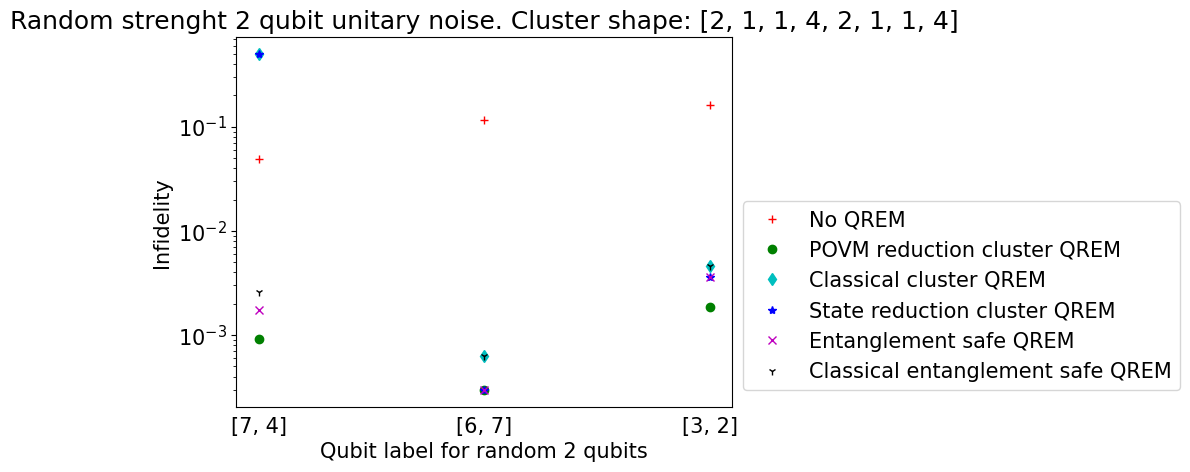

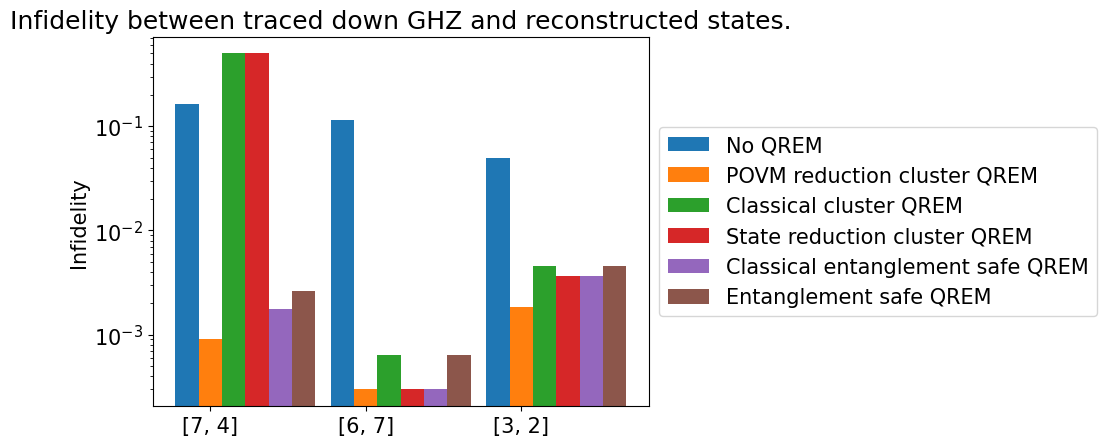

In [90]:

# Plotting
#data_path = "QDOT_results/2024-08-01_13-23-06_9debe732-8fc3-49b5-bdde-ef8b208d43b5"
with open(f'{data_path}/result_inf.npy', 'rb') as f:
    result_dict =  np.load(f, allow_pickle=True).item()

averaged_classical_cluster_QREM_inf_array = result_dict['averaged_classical_cluster_QREM_inf_array']
averaged_factorized_QREM_inf_array = result_dict['averaged_factorized_QREM_inf_array']
averaged_no_QREM_inf_array = result_dict['averaged_no_QREM_inf_array']
averaged_povm_reduction_inf_array = result_dict['averaged_povm_reduction_inf_array']
averaged_two_RDM_QREM_inf_array = result_dict['averaged_two_RDM_QREM_inf_array']
averaged_state_reduction_inf_array = result_dict['averaged_state_reduction_inf_array']
averaged_entanglement_safe_QREM_inf_array = result_dict['averaged_entanglement_safe_QREM_inf_array']
averaged_classical_entanglement_safe_QREM_inf_array = result_dict['averaged_classical_entanglement_safe_QREM_inf_array']





no_QREM_inf_array = result_dict['no_QREM_inf_array']
factorized_QREM_inf_array = result_dict['factorized_QREM_inf_array']
two_RDM_QREM_inf_array = result_dict['two_RDM_QREM_inf_array']
povm_reduction_inf_array = result_dict['povm_reduction_inf_array']
classical_cluster_QREM_inf_array = result_dict['classical_cluster_QREM_inf_array']
state_reduction_inf_array = result_dict['state_reduction_inf_array']
entanglement_safe_QREM_inf_array = result_dict['entanglement_safe_QREM_inf_array']
classical_entangelment_safe_QREM_inf_array = result_dict['classical_entangelment_safe_QREM_inf_array']



it = 0
cluster_plotting_list = []
for i in range(n_clusters): # To print out the labels that are related. 
    cluster_plotting_list.append(list(ot.qubit_label_to_list_index(np.arange(it, it + cluster_size[i]),sum(cluster_size))))
    it+=cluster_size[i]


text_string = 'Cluster label structure:\n'
for i, cluster in enumerate(cluster_plotting_list):
    text_string += f'Cluster {i}: {cluster}\n'
props = dict(boxstyle='round', facecolor='white', alpha=0.5)

noise_titles = ['Depolarizing noise',"Random unitary noise", 'Random strenght 2 qubit unitary noise']

x = np.arange(len(two_point_corr_labels))
corr_x_label = [f'[{label[0]}, {label[1]}]' for label in two_point_corr_labels]
plt.title(f"{noise_titles[noise_mode-1]}. Cluster shape: {cluster_size}")
plt.plot(corr_x_label, averaged_no_QREM_inf_array, 'r+', label = 'No QREM')
#plt.plot(corr_x_label, averaged_factorized_QREM_inf_array, 'y1', label = 'Factorized QREM')
#plt.plot(corr_x_label, averaged_two_RDM_QREM_inf_array,  'kx',label = 'Correlator only (2RDM) QREM')
plt.plot(corr_x_label, averaged_povm_reduction_inf_array, 'go', label = 'POVM reduction cluster QREM')
plt.plot(corr_x_label, averaged_classical_cluster_QREM_inf_array, 'cd', label = 'Classical cluster QREM')
plt.plot(corr_x_label, averaged_state_reduction_inf_array, 'b*', label = 'State reduction cluster QREM')
plt.plot(corr_x_label, averaged_entanglement_safe_QREM_inf_array, 'mx', label = 'Entanglement safe QREM')
plt.plot(corr_x_label, averaged_classical_entanglement_safe_QREM_inf_array, 'k1', label = 'Classical entanglement safe QREM')

# transparency = 0
# for i in range(n_averages):
#     plt.plot(x, no_QREM_inf_array[i], 'r+', alpha = transparency)
#     plt.plot(x, factorized_QREM_inf_array[i], 'y1', alpha = transparency)
#     plt.plot(x, two_RDM_QREM_inf_array[i], 'kx', alpha = transparency)
#     plt.plot(x, povm_reduction_inf_array[i], 'go', alpha = transparency)
#     plt.plot(x, classical_cluster_QREM_inf_array[i], 'cd', alpha = transparency)
#     plt.plot(x, state_reduction_inf_array[i], 'b*', alpha = transparency)



plt.yscale('log')
plt.ylabel('Infidelity')
plt.xlabel('Qubit label for random 2 qubits')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off
plt.legend(loc='center left', bbox_to_anchor=(1, 0.3))

#plt.text(10, 0.3, text_string, fontsize=14,
#        verticalalignment='top', bbox=props)


#legends = [f'[]','DE','CF','FG']


data = {'No QREM':averaged_no_QREM_inf_array[::-1],
        #'Factorized QREM':facotrized_QREM_MSE[::-1],
        #'2-point correlator QREM':two_RDM_exp_MSE[::-1],
        'POVM reduction cluster QREM': averaged_povm_reduction_inf_array,
        'Classical cluster QREM': averaged_classical_cluster_QREM_inf_array,
        'State reduction cluster QREM': averaged_state_reduction_inf_array,
        'Classical entanglement safe QREM': averaged_entanglement_safe_QREM_inf_array,
        'Entanglement safe QREM': averaged_classical_entanglement_safe_QREM_inf_array
        }
#x = np.arange(len(two_point_corr_labels))
#x = [f'[{label[0]}, {label[1]}]' for label in two_point_corr_labels][:cutoff]

x = np.arange(len(corr_x_label))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots() 

for attribute, measurement in data.items():
    offset = width * multiplier
    print(measurement)
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    #ax.bar_label(rects, padding=3)
    multiplier += 1
ax.set_yscale('log')
ax.set_title(rf"Infidelity between traced down GHZ and reconstructed states.")
ax.set_xticks(x + width, corr_x_label)
ax.set_ylabel('Infidelity')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [95]:
# Plotting random correlator result
plt.rcParams.update({'font.size': 15})


with open(f'{data_path}/result_QST.npy', 'rb') as f:
    result_dict =  np.load(f, allow_pickle=True).item()


true_rho_average_array = result_dict['true_rho_average_array']
state_reduction_rho_average_array = result_dict['state_reduction_rho_average_array']
two_RDM_QREM_rho_average_array = result_dict['two_RDM_QREM_rho_average_array']
no_QREM_rho_average_array = result_dict['no_QREM_rho_average_array']
povm_reduction_rho_average_array = result_dict['povm_reduction_rho_average_array']
factorized_QREM_rho_average_array = result_dict['factorized_QREM_rho_average_array']
classical_cluster_QREM_rho_average_array = result_dict['classical_cluster_QREM_rho_average_array']
entanglement_safe_QREM_rho_average_array = result_dict['entanglement_safe_QREM_rho_average_array']
classical_entangelment_safe_QREM_rho_average_array = result_dict['classical_entangelment_safe_QREM_rho_average_array']
two_point_corr_labels   = result_dict['two_point_corr_labels']
print(povm_reduction_rho_average_array)

def factorized_state_list_to_correlator_states(two_point_corr_labels, factorized_state_list, n_qubits):
    """
    Function converts a list of factorized states to a list of correlator states.
    """
    correlator_states = []
    for j in range(len(factorized_state_list)):
        correlator_states.append([])
        for i in range(len(two_point_corr_labels)):
            subsystem_index = ot.qubit_label_to_list_index(np.sort(two_point_corr_labels[i])[::-1], n_qubits) 
            qubit_sublist = factorized_state_list[j][subsystem_index]
            correlator_states[j].append(reduce(np.kron, qubit_sublist))
    return correlator_states

#true_state_list = factorized_state_list_to_correlator_states(two_point_corr_labels, true_rho_average_array,12)
def generate_random_pauli_string(n_samples,n_qubits):
    """
    Function generates a random Pauli string of length n_elements.
    """
    pauli_1 = np.eye(2)
    pauli_x = np.array([[0,1],[1,0]])
    pauli_y = np.array([[0,-1j],[1j,0]])
    pauli_z = np.array([[1,0],[0,-1]])
    pauli_operators = np.array([pauli_1,pauli_x, pauli_y, pauli_z])
    pauli_string = np.random.randint(0,4,n_samples*n_qubits).reshape(n_samples,n_qubits)
    op_list = pauli_operators.take(pauli_string,axis = 0)  
    return np.array([reduce(np.kron, op_list[i]) for i in range(n_samples)]) 



def compute_exp_value(rho_average_array,pauli_string):
    """
    Function computes the expectation value of a Pauli string for a given state array.
    """

    return np.einsum('nijk,lkj->nil', rho_average_array, pauli_string).real

def compute_MSE(true_exp_value, exp_value):
    """
    Function computes the mean squared error between two sets of density matrices.
    """
    return np.mean((true_exp_value - exp_value)**2,axis = (0,2))

Z = np.array([[1,0],[0,-1]])

op_string = np.array([Z,Z])

op_string = [reduce(np.kron, op_string)]

no_QREM_exp_value = compute_exp_value(no_QREM_rho_average_array,op_string)
state_reduction_exp_value = compute_exp_value(state_reduction_rho_average_array,op_string)
#two_RDM_QREM_exp_value = compute_exp_value(two_RDM_QREM_rho_average_array,op_string)
povm_reduction_exp_value = compute_exp_value(povm_reduction_rho_average_array,op_string)
#factorized_QREM_exp_value = compute_exp_value(factorized_QREM_rho_average_array,op_string)
classical_cluster_QREM_exp_value = compute_exp_value(classical_cluster_QREM_rho_average_array,op_string)
entanglement_safe_QREM_exp_value = compute_exp_value(entanglement_safe_QREM_rho_average_array,op_string)
classical_entangelment_safe_QREM_exp_value = compute_exp_value(classical_entangelment_safe_QREM_rho_average_array,op_string)
true_exp_value = 1


no_QREM_MSE = compute_MSE(true_exp_value, no_QREM_exp_value)
classical_cluster_QREM_MSE = compute_MSE(true_exp_value, classical_cluster_QREM_exp_value)
#facotrized_QREM_MSE = compute_MSE(true_exp_value, factorized_QREM_exp_value)
#two_RDM_exp_MSE = compute_MSE(true_exp_value, two_RDM_QREM_exp_value)
povm_reduction_exp_value_MSE = compute_MSE(true_exp_value, povm_reduction_exp_value)
state_reduction_MSE = compute_MSE(true_exp_value, state_reduction_exp_value)
entanglement_safe_QREM_MSE = compute_MSE(true_exp_value, entanglement_safe_QREM_exp_value)
classical_entangelment_safe_QREM_MSE = compute_MSE(true_exp_value, classical_entangelment_safe_QREM_exp_value)

print(no_QREM_MSE)
print(classical_cluster_QREM_MSE)
legends = ['AB','DE','CF','FG']
data = {'No QREM':no_QREM_MSE[::-1],
        #'Factorized QREM':facotrized_QREM_MSE[::-1],
        #'2-point correlator QREM':two_RDM_exp_MSE[::-1],
        'POVM reduction cluster QREM': povm_reduction_exp_value_MSE[::-1],
        'Classical cluster QREM': classical_cluster_QREM_MSE[::-1],
        'State reduction cluster QREM': state_reduction_MSE[::-1],
        'Classical entanglement safe QREM': classical_entangelment_safe_QREM_MSE[::-1],
        'Entanglement safe QREM': entanglement_safe_QREM_MSE[::-1]
        }
#x = np.arange(len(two_point_corr_labels))
#x = [f'[{label[0]}, {label[1]}]' for label in two_point_corr_labels][:cutoff]

x = np.arange(len(corr_x_label))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots()

for attribute, measurement in data.items():
    offset = width * multiplier
    print(measurement)
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    #ax.bar_label(rects, padding=3)
    multiplier += 1
ax.set_yscale('log')
ax.set_title(rf"MSE of $\langle ZZ \rangle$ correlator for GHZ states")
# plt.plot(x, no_QREM_MSE[:cutoff], 'r+', label = 'No QREM')
# plt.plot(x, facotrized_QREM_MSE[:cutoff], 'y1', label = 'Factorized QREM')
# plt.plot(x, two_RDM_exp_MSE[:cutoff],  'kx',label = 'Correlator only (2RDM) QREM')
# #plt.plot(x, averaged_povm_reduction_inf_array, 'go', label = 'POVM reduction cluster QREM')
# plt.plot(x, classical_cluster_QREM_MSE[:cutoff], 'cd', label = 'Classical cluster QREM')
# plt.plot(x, state_reduction_MSE[:cutoff], 'b*', label = 'State reduction cluster QREM')

ax.set_xticks(x + width, corr_x_label)

plt.ylabel('MSE')
plt.xlabel('Correlator qubit labels')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off


plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#plt.text(10, 0.3, text_string, fontsize=14,verticalalignment='top', bbox=props)


[]


ValueError: einstein sum subscripts string contains too many subscripts for operand 0

Testbench for checking if using POVM reduction method works for entangled states. 

In [96]:
# Comparing tracing down POVM vs tracing down final reconstructed state. 
bell_state = np.array([[1, 0, 0, 1], 
                       [0, 0, 0, 0], 
                       [0, 0, 0, 0], 
                       [1, 0, 0, 1]]) / 2
n_qubits = 2
n_QDT_shots = 10**4
print("Bell state density matrix:")
print(bell_state)
true_state = sf.generate_random_pure_state(n_qubits)
# Define nosy 2 qubit POVM
base_POVM = POVM.generate_computational_POVM(2)[0]
noisy_POVM = POVM.generate_noisy_POVM(base_POVM, noise_mode=3)
calib,_ = sf.get_calibration_states(n_qubits)
recon_POVM = dt.device_tomography(n_qubits,n_QDT_shots,[noisy_POVM],calib)
noisy_pauli_6 = POVM.generate_Pauli_from_comp(noisy_POVM)#POVM.generate_Pauli_POVM(n_qubits)
print(f'POVM distance:{sf.POVM_distance(noisy_POVM.get_POVM(),recon_POVM[0].get_POVM())}')
povm_list = np.array([povm.get_POVM() for povm in noisy_pauli_6])

outcomes = np.array([ povm.get_histogram(true_state) for povm in noisy_pauli_6])
n_qst_shot = 10**10
index_counts = outcomes *n_qst_shot
index_counts = index_counts.flatten()
two_qubit_povm = povm_list.copy()
# Reconstruct the  2 qubit state
two_qubit_povm = two_qubit_povm.reshape(-1,4,4)

two_qubit_rho_recon = QST.iterative_MLE_index(index_counts,two_qubit_povm)

two_qubit_trace_down_recon  = sf.partial_trace(two_qubit_rho_recon)
# Reconstruc the traced down state
povm_trace = np.array([[sf.partial_trace(element)for element in povm ] for povm in povm_list])
trace_down_rho_true = sf.partial_trace(true_state)



povm_trace = povm_trace.reshape(-1,2,2)

one_qubit_rho_recon = QST.iterative_MLE_index(index_counts,povm_trace)

print(f'Infidelity for traced down POVM: {sf.qubit_infidelity(one_qubit_rho_recon,trace_down_rho_true)}')
print(f'Infidelity for 2 qubit: {sf.qubit_infidelity(two_qubit_trace_down_recon,trace_down_rho_true)}')
print(f'Purity for traced down POVM: {sf.purity(one_qubit_rho_recon)}, {sf.purity(two_qubit_trace_down_recon)}, {sf.purity(trace_down_rho_true)}')



Bell state density matrix:
[[0.5 0.  0.  0.5]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.5 0.  0.  0.5]]
Done collecting and sorting QDT data, total runtime 0.005950450897216797.
Starting POVM reconstruction.
	Number of MLE iterations: 2000, final distance 3.6221569632566286e-09
Runtime of parallel POVM reconstruction 0.7340867519378662
POVM distance:0.004371960034514705
Infidelity for traced down POVM: 0.18605118348581107
Infidelity for 2 qubit: 1.0643665104836941e-07
Purity for traced down POVM: 0.9999999999999227, 0.730711240715225, 0.7309181555977958


# Brute force perfect hash family search 

In [3]:
# Define the hash parameters you want. 

n = 16
k = 4
timeout = 300 #10 * 3600   # [seconds]
target_size = 5
timeout_start = time.time()

perfect_hash = ot.generate_kRDm_hash_brute(n,k)
best_hash = perfect_hash
size = len(perfect_hash)
it = 1
while time.time() < timeout_start + timeout:
    perfect_hash = ot.generate_kRDm_hash_brute(n,k)
    
    temp_size = len(perfect_hash)
    if temp_size < size:
        size = temp_size
        print(f'Hash length: {size}, iteration: {it},  time_found: {time.time() - timeout_start}')
        best_hash = perfect_hash
        if size == target_size:
            break
    it+=1
print(f"Time spent: {time.time() - timeout_start}.")
path = "EMQST_lib/hash_family/"
print(best_hash)
with open(f'{path}perfect_hash({size},{n},{k}).npy', 'wb') as f:
    np.save(f, best_hash)

Hash length: 13, iteration: 1,  time_found: 12.387504577636719
Hash length: 12, iteration: 16,  time_found: 90.56743359565735
Hash length: 10, iteration: 37,  time_found: 165.96325397491455
Hash length: 9, iteration: 69,  time_found: 272.04061937332153
Time spent: 302.2057726383209.
[[0 1 2 3 0 1 2 3 0 1 2 3 0 1 2 3]
 [1 2 1 0 0 2 3 3 3 0 1 2 2 0 1 3]
 [2 2 3 0 1 0 0 0 1 2 1 3 3 3 2 1]
 [0 3 1 2 0 1 3 1 2 3 1 2 0 3 0 2]
 [0 2 2 1 0 0 3 2 3 3 1 1 0 1 3 2]
 [0 1 3 2 2 3 1 3 0 2 0 2 1 0 3 1]
 [3 1 1 3 2 1 2 2 0 0 3 0 1 3 0 2]
 [1 0 3 3 2 1 2 0 3 0 1 2 2 1 3 0]
 [3 0 0 1 3 2 3 1 3 2 1 2 0 2 0 1]]
